### RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

**Recency:** It measures how recently you visited the store or made a purchase

**Frequency:** It measures the frequency of the transactions the customers made

**Monetary:** It measures how much the customer spent on purchases he/she made

 

So, your target is to compute the RFM numbers for each customer, which effectively means that the granularity level of your data set will change from Invoice number to the CustomerID. Thus, you will have one unique row corresponding to each customer.

In [2]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
#reading Dataset
retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Sanity Check
retail.head()
retail.shape
retail.describe()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [6]:
#dropping the na cells
order_wise = retail.dropna()

In [7]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [9]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)
order_wise.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [12]:
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head(20)

C:\Users\shesmeg\AppData\Local\Temp\ipykernel_2612\688434607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff'] = maximum - recency.InvoiceDate


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00
5,17850.0,2010-12-01 08:26:00,374 days 04:24:00
6,17850.0,2010-12-01 08:26:00,374 days 04:24:00
7,17850.0,2010-12-01 08:28:00,374 days 04:22:00
8,17850.0,2010-12-01 08:28:00,374 days 04:22:00
9,13047.0,2010-12-01 08:34:00,374 days 04:16:00


In [15]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').agg({'diff': ['min']}))
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [16]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()
RFM.shape

(4372, 4)

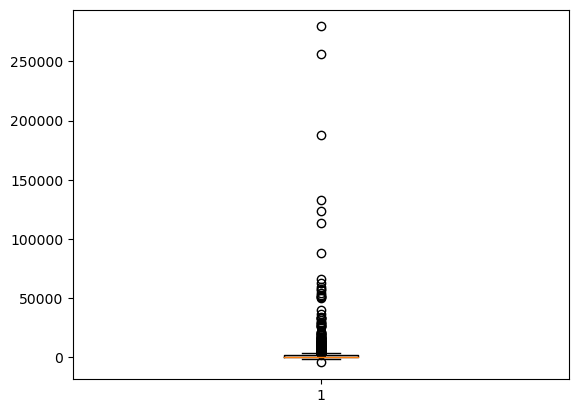

In [17]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

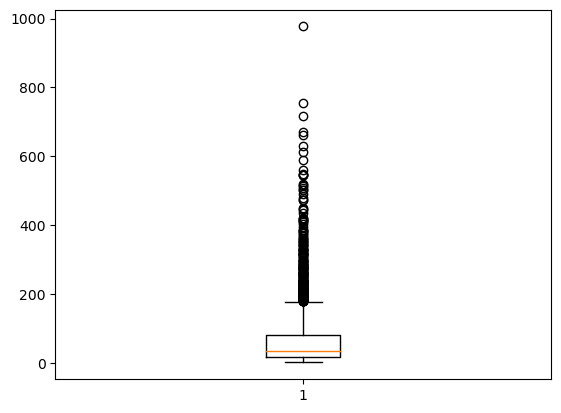

In [18]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

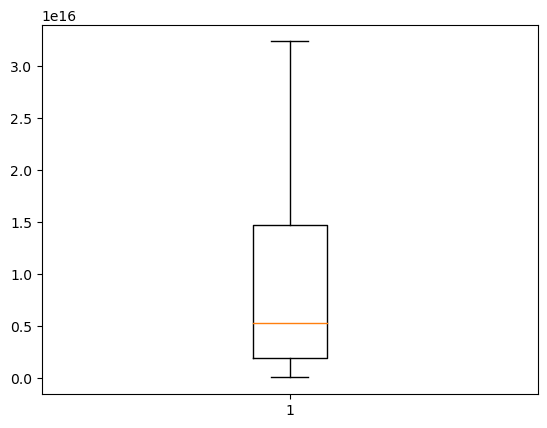

In [19]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [20]:
RFM.shape

(3697, 4)

In [21]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


In [22]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days
RFM_norm1.head()



,Frequency,Amount,Recency
0,2,0.00,326
2,31,1797.24,75
3,73,1757.55,19
4,17,334.40,310
5,95,1545.41,36


In [23]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norm1)

array([[-1.07094871, -1.04161396,  2.13642223],
       [-0.3754979 ,  1.38529792, -0.28204953],
       [ 0.63170672,  1.33170234, -0.82162889],
       ...,
       [-0.9510434 , -0.93247827,  0.73929711],
       [-0.80715703, -0.80314128, -0.92761769],
       [ 0.55976353,  1.43936613, -0.59038059]])

## Notes

Let's try to understand KMeans and the different parameters from Scikit Learn Documentation:

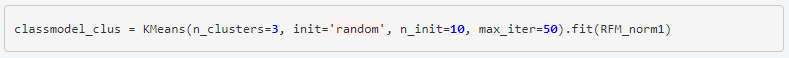

**n_clusters:** The number of clusters to form as well as the number of centroids to generate\
**init:** Method for initialization of the cluster centres\
**n_init:** Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. \
**max_iter:** Maximum number of iterations of the k-means algorithm for a single run in case it doesn't converge on its own

Let's understand the output of the KMeans() function.

**cluster_centers:** Coordinates of cluster centres\
**labels:** Labels of each point i.e. the labels to which the points belong\
**inertia:** Sum of squared distances of points to their closest cluster centre

In [24]:
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

In [25]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_km.head(50)


,CustomerID,Frequency,Amount,Recency,ClusterID
0,12346.0,2,0.00,326 days 02:33:00,0
1,12348.0,31,1797.24,75 days 23:37:00,4
2,12349.0,73,1757.55,19 days 02:59:00,4
3,12350.0,17,334.40,310 days 20:49:00,0
4,12352.0,95,1545.41,36 days 22:13:00,1
5,12353.0,4,89.00,204 days 19:03:00,0
6,12354.0,58,1079.40,232 days 23:39:00,1
7,12355.0,13,459.40,214 days 23:01:00,3
8,12356.0,59,2811.43,23 days 04:10:00,2
9,12358.0,19,1168.06,2 days 02:24:00,1


In [26]:
RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [27]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,225.822616,21.189707,147.131658
1,1,1208.866765,68.530499,60.293900
2,2,2888.302675,117.905759,41.052356
3,3,652.153543,49.609553,84.898235
4,4,1935.628973,89.782477,52.631420


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

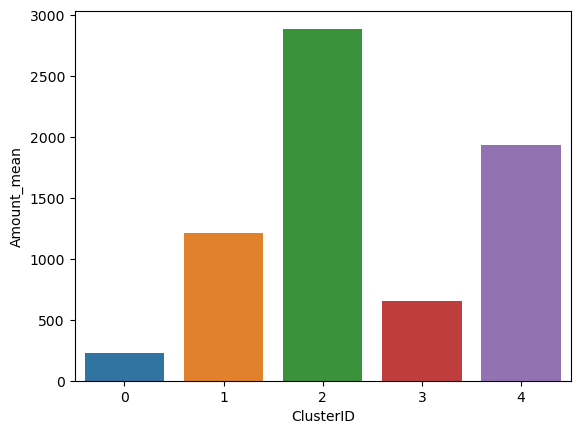

In [28]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

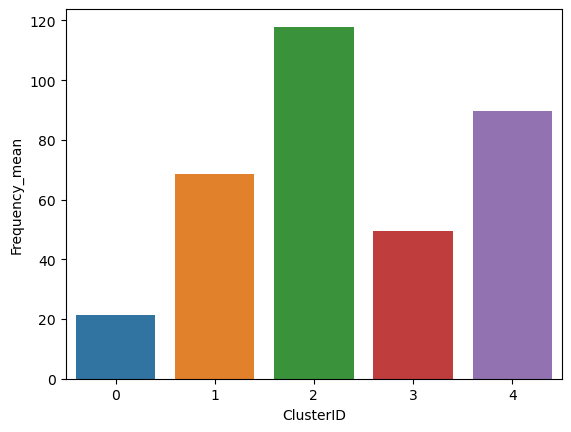

In [29]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

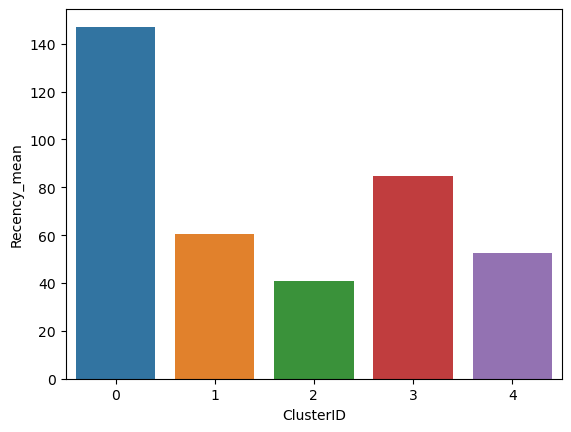

In [30]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

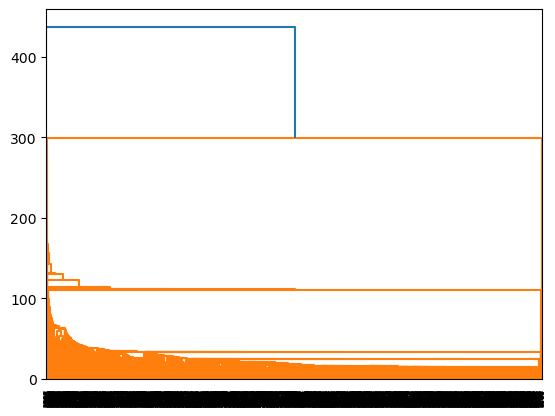

In [31]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

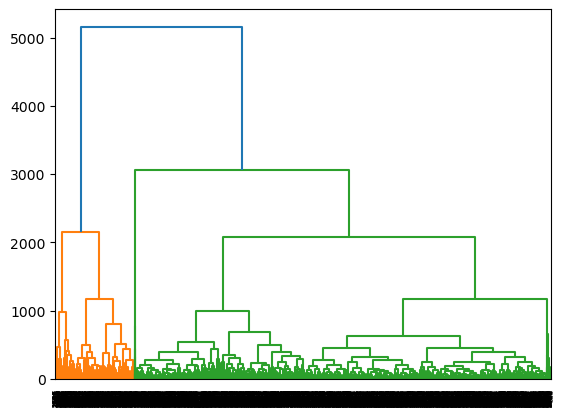

In [32]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [33]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [34]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [35]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,252.966698,22.707291,142.854733
1,1,1919.512313,92.709751,50.852608
2,2,867.327807,56.955626,73.369255
3,3,2990.865636,118.920530,44.165563
4,4,-1183.350000,7.800000,248.200000


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

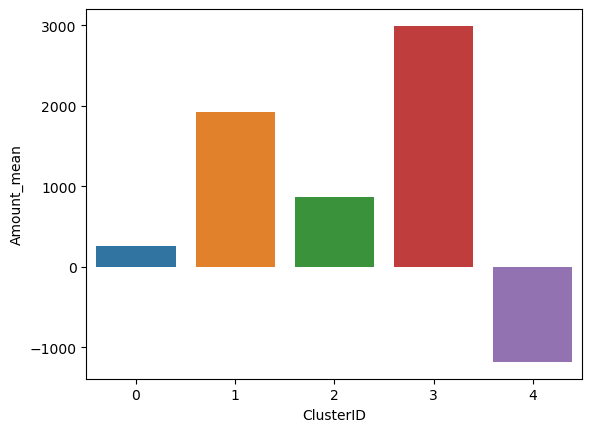

In [36]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

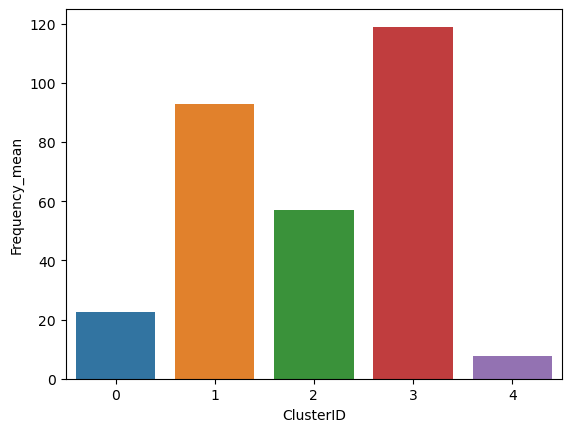

In [37]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

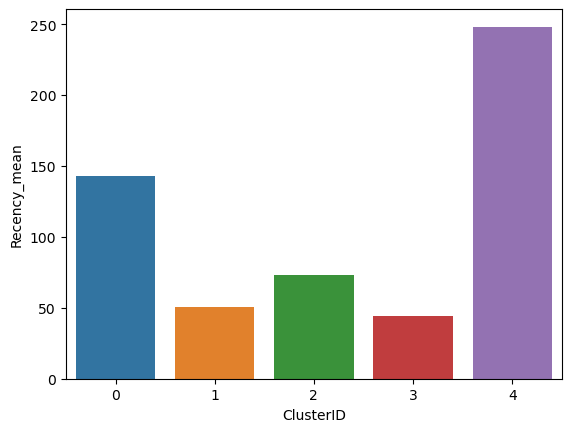

In [38]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)